In [170]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

In [171]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.splitters import KFold
from berp.generators import thresholded_recognition_simple as generator
from berp.generators.stimulus import RandomStimulusGenerator
from berp.models.reindexing_regression import ModelParameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate grouped dataset

In [172]:
synth_params = ModelParameters(
    lambda_=torch.tensor(1.0),
    confusion=generator.phoneme_confusion,
    threshold=torch.distributions.Beta(1.2, 1.2).sample(),

    # NB only used for generation, not in model
    a=torch.tensor(0.2),
    b=torch.tensor(0.1),
    coef=torch.tensor([-1]),
    sigma=torch.tensor(5.0),
)

sample_rate = 48
num_subjects = 2

In [173]:
stim = RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=synth_params.confusion.shape[0],
                               word_surprisal_params=(2.0, 0.5))
ds_args = dict(
    response_type="gaussian",
    epoch_window=(0, 0.55), # TODO unused
    include_intercept=False,
    sample_rate=sample_rate)

# Pass a thunk to the dataset generator which returns the same thing every time
stim = stim(align_sample_rate=sample_rate)
stim_thunk = lambda: stim

datasets = []
for subject in range(num_subjects):
    ds_i = generator.sample_dataset(synth_params, stim_thunk, **ds_args)
    ds_i.name = f"synth_{subject}"
    datasets.append(ds_i)

In [174]:
nested_dataset = NestedBerpDataset(datasets, n_splits=20)

## Prepare plotting function

In [175]:
plt.cm.viridis(np.array([[0.5, 0.2], [0.3, 0.1]]))

array([[[0.127568, 0.566949, 0.550556, 1.      ],
        [0.253935, 0.265254, 0.529983, 1.      ]],

       [[0.206756, 0.371758, 0.553117, 1.      ],
        [0.282623, 0.140926, 0.457517, 1.      ]]])

In [195]:
def plot_assignments(dataset: NestedBerpDataset, assignments: np.ndarray, ax=None):
    assert assignments.shape == (len(dataset.datasets), max(len(ds) for ds in dataset.datasets))
        
    if ax is None:
        f, ax = plt.subplots(figsize=(15, 7))

    max_time_len = max(len(ds) for ds in dataset.datasets)
    ds_to_idx = {ds.name: i for i, ds in enumerate(dataset.datasets)}

    # num_assignment_types = assignments.max() + 1
    # cmap = colors.ListedColormap(list(colors.CSS4_COLORS.keys())[:num_assignment_types])
    # print(list(colors.CSS4_COLORS.keys())[:num_assignment_types])
    # bounds = np.arange(num_assignment_types + 1)
    # norm = colors.BoundaryNorm(bounds, cmap.N)
    # print(bounds)
    im = ax.imshow(assignments, aspect="auto")#, cmap=cmap, norm=norm)

    xticks = np.linspace(0, max_time_len, num=10)
    ax.set_xticks(ticks=xticks, labels=(xticks / nested_dataset.sample_rate).round(3))
    ax.set_yticks(np.arange(len(nested_dataset.datasets)))

    ax.set_xlabel("Time")
    ax.set_ylabel("Subject")
    
    plt.colorbar(mappable=im, ax=ax)
    plt.grid()

In [190]:
def plot_splitter(dataset: NestedBerpDataset, splitter, ax=None, **split_kwargs):
    """
    Plot test fold index for each data slice.
    """
    max_time_len = max(len(ds) for ds in dataset.datasets)
    assignments = np.zeros((len(dataset.datasets), max_time_len), dtype=np.int32)
    ds_to_idx = {ds.name: i for i, ds in enumerate(dataset.datasets)}
    
    for split, (train, test) in enumerate(splitter.split(dataset, **split_kwargs)):
        for sub_ds in dataset[test]:
            source_dataset = sub_ds.name.split("/")[0]
            start, end = sub_ds.global_slice_indices
            assignments[ds_to_idx[source_dataset], start:end] = split

    plot_assignments(dataset, assignments, ax=ax)
    
# def plot_splitter_draws(dataset: NestedBerpDataset, splitter, **split_kwargs):
#     """
#     Plot the actual train/test split for each draw from the splitter.
#     """
    
#     f, axs = plt.subplots(splitter.n_splits, figsize=(5, 20))
    
#     for split, (ax, (train, test)) in enumerate(zip(axs, splitter.split(dataset, **split_kwargs))):
#         assignments = np.zeros(len(dataset), dtype=np.int32)
#         assignments[train] = 0
#         assignments[test] = 1
#         plot_assignments(dataset, assignments, ax=ax)

### Demo plot

In [191]:
from sklearn.model_selection import KFold as sk_KFold

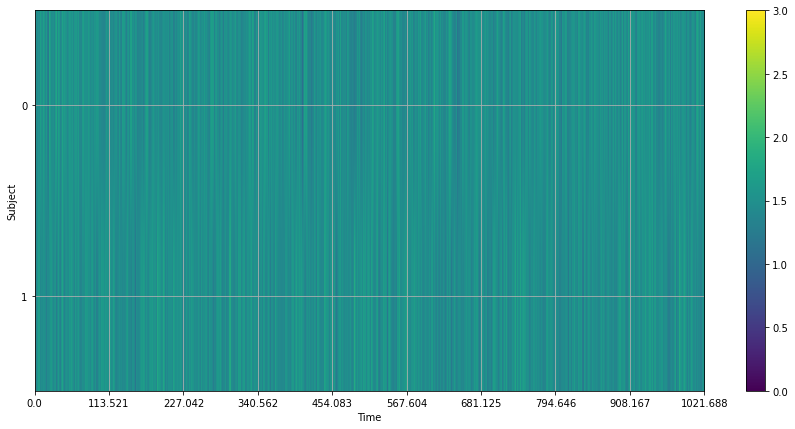

In [196]:
assignments = np.random.randint(0, 4, size=(len(nested_dataset.datasets), max(len(ds) for ds in nested_dataset.datasets)))
plot_assignments(nested_dataset, assignments)

## Real plots

### KFold

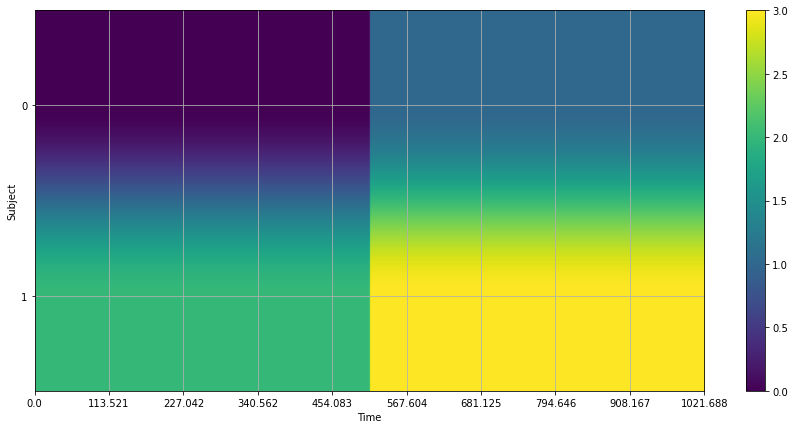

In [197]:
nested_dataset.order_by_dataset()
plot_splitter(nested_dataset, sk_KFold(4))

### Ours

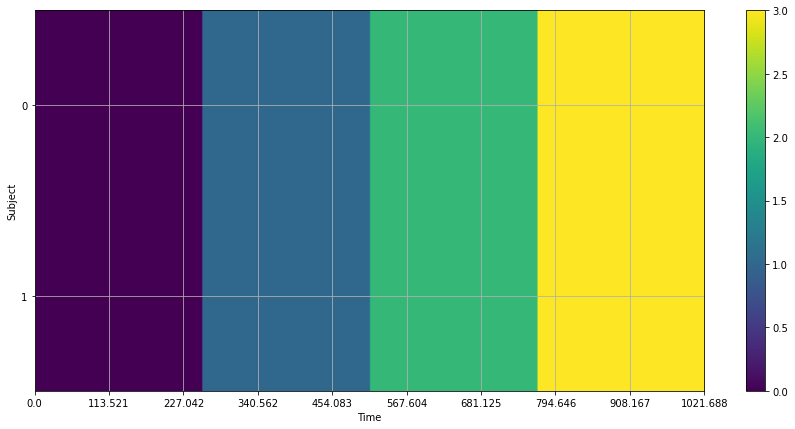

In [198]:
plot_splitter(nested_dataset, KFold(4))